In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import imblearn
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [3]:

train_data = pd.read_csv('train.csv')

Renaming Columns

In [4]:
# Remove quotes and replace spaces with underscores
train_data.columns = [col.strip().replace("'", '').replace(' ', '_') for col in train_data.columns]



In [5]:
train_data = train_data.rename(columns={
    'Genes_in_mothers_side': 'Genes_Mothers_Side',
    'Inherited_from_father': 'Inherited_Father',
    'Blood_cell_count_(mcL)': 'Blood_Cell_mcL',
    'Respiratory_Rate_(breaths/min)': 'Respiratory_Rate_breaths_min',
    'Heart_Rate_(rates/min': 'Heart_Rates_Min',
    'Follow-up': 'Follow_up',
    'Autopsy_shows_birth_defect_(if_applicable)': 'Autopsy_Birth_Defect',
    'Folic_acid_details_(peri-conceptional)': 'Folic_Acid',
    'H/O_serious_maternal_illness': 'Maternal_Illness',
    'H/O_radiation_exposure_(x-ray)': 'Radiation_Exposure',
    'H/O_substance_abuse': 'Substance_Abuse',
    'Assisted_conception_IVF/ART': 'Assisted_Conception',
    'History_of_anomalies_in_previous_pregnancies': 'History_Previous_Pregnancies',
    'No._of_previous_abortion': 'Previous_Abortion',
    'Birth_defects': 'Birth_Defects',
    'White_Blood_cell_count_(thousand_per_microliter)': 'White_Blood_Cell',
})

In [6]:
train_data.columns

Index(['Patient_Id', 'Patient_Age', 'Genes_Mothers_Side', 'Inherited_Father',
       'Maternal_gene', 'Paternal_gene', 'Blood_Cell_mcL',
       'Patient_First_Name', 'Family_Name', 'Fathers_name', 'Mothers_age',
       'Fathers_age', 'Institute_Name', 'Location_of_Institute', 'Status',
       'Respiratory_Rate_breaths_min', 'Heart_Rates_Min', 'Test_1', 'Test_2',
       'Test_3', 'Test_4', 'Test_5', 'Parental_consent', 'Follow_up', 'Gender',
       'Birth_asphyxia', 'Autopsy_Birth_Defect', 'Place_of_birth',
       'Folic_Acid', 'Maternal_Illness', 'Radiation_Exposure',
       'Substance_Abuse', 'Assisted_Conception',
       'History_Previous_Pregnancies', 'Previous_Abortion', 'Birth_Defects',
       'White_Blood_Cell', 'Blood_test_result', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5', 'Genetic_Disorder',
       'Disorder_Subclass'],
      dtype='object')

If Genetic_Disorder is NaN, removing those rows

In [7]:
# Drop rows where 'Genetic_Disorder' is NaN
train_data.dropna(subset=['Genetic_Disorder'], inplace=True)

# Reset the index to update row numbers and avoid keeping the old index
train_data.reset_index(drop=True, inplace=True)

Dropping the unnecessary data columns - Based on Optimised Paper

In [8]:
train_data = train_data.drop(columns=['Patient_Id','Patient_First_Name', 'Family_Name',
       'Fathers_name','Institute_Name', 'Place_of_birth',
       'Location_of_Institute', 'Test_1', 'Test_2', 'Test_3', 'Test_4',
       'Test_5', 
       'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5'])

In [9]:
train_data.duplicated().sum()

0

In [10]:
train_data.columns

Index(['Patient_Age', 'Genes_Mothers_Side', 'Inherited_Father',
       'Maternal_gene', 'Paternal_gene', 'Blood_Cell_mcL', 'Mothers_age',
       'Fathers_age', 'Status', 'Respiratory_Rate_breaths_min',
       'Heart_Rates_Min', 'Parental_consent', 'Follow_up', 'Gender',
       'Birth_asphyxia', 'Autopsy_Birth_Defect', 'Folic_Acid',
       'Maternal_Illness', 'Radiation_Exposure', 'Substance_Abuse',
       'Assisted_Conception', 'History_Previous_Pregnancies',
       'Previous_Abortion', 'Birth_Defects', 'White_Blood_Cell',
       'Blood_test_result', 'Genetic_Disorder', 'Disorder_Subclass'],
      dtype='object')

In [11]:
print(train_data["Genes_Mothers_Side"].value_counts())

Genes_Mothers_Side
Yes    11848
No      8089
Name: count, dtype: int64


In [12]:
print(train_data['Genetic_Disorder'].value_counts())

Genetic_Disorder
Mitochondrial genetic inheritance disorders     10202
Single-gene inheritance diseases                 7664
Multifactorial genetic inheritance disorders     2071
Name: count, dtype: int64


In [13]:
def get_unique(train_data):
    for i in train_data.columns:
        print(f'{i} - > {len(train_data[i].unique())}')
get_unique(train_data)

Patient_Age - > 16
Genes_Mothers_Side - > 2
Inherited_Father - > 3
Maternal_gene - > 3
Paternal_gene - > 2
Blood_Cell_mcL - > 19937
Mothers_age - > 35
Fathers_age - > 46
Status - > 2
Respiratory_Rate_breaths_min - > 3
Heart_Rates_Min - > 3
Parental_consent - > 2
Follow_up - > 3
Gender - > 4
Birth_asphyxia - > 5
Autopsy_Birth_Defect - > 4
Folic_Acid - > 3
Maternal_Illness - > 3
Radiation_Exposure - > 5
Substance_Abuse - > 5
Assisted_Conception - > 3
History_Previous_Pregnancies - > 3
Previous_Abortion - > 6
Birth_Defects - > 3
White_Blood_Cell - > 15682
Blood_test_result - > 5
Genetic_Disorder - > 3
Disorder_Subclass - > 10


In [14]:
# Continuous features with median imputation
train_data['Patient_Age'].fillna(train_data['Patient_Age'].median(), inplace=True)
train_data['Blood_Cell_mcL'].fillna(train_data['Blood_Cell_mcL'].median(), inplace=True)
train_data['White_Blood_Cell'].fillna(train_data['White_Blood_Cell'].median(), inplace=True)

# Categorical/ordinal features with mode imputation
columns_to_fill_mode = [
    'Genes_Mothers_Side', 'Inherited_Father', 'Maternal_gene', 'Paternal_gene','Mothers_age',
    'Fathers_age','Status', 'Respiratory_Rate_breaths_min', 'Heart_Rates_Min', 
    'Parental_consent', 'Follow_up', 'Gender', 'Birth_asphyxia','Autopsy_Birth_Defect',  
    'Folic_Acid', 
    'Maternal_Illness', 'Radiation_Exposure', 
    'Substance_Abuse', 'Assisted_Conception', 
    'History_Previous_Pregnancies','Previous_Abortion', 'Birth_Defects', 
    'Blood_test_result', 'Disorder_Subclass'
]

for col in columns_to_fill_mode:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)



In [15]:
train_data.isnull().sum()

Patient_Age                     0
Genes_Mothers_Side              0
Inherited_Father                0
Maternal_gene                   0
Paternal_gene                   0
Blood_Cell_mcL                  0
Mothers_age                     0
Fathers_age                     0
Status                          0
Respiratory_Rate_breaths_min    0
Heart_Rates_Min                 0
Parental_consent                0
Follow_up                       0
Gender                          0
Birth_asphyxia                  0
Autopsy_Birth_Defect            0
Folic_Acid                      0
Maternal_Illness                0
Radiation_Exposure              0
Substance_Abuse                 0
Assisted_Conception             0
History_Previous_Pregnancies    0
Previous_Abortion               0
Birth_Defects                   0
White_Blood_Cell                0
Blood_test_result               0
Genetic_Disorder                0
Disorder_Subclass               0
dtype: int64

In [16]:
print("Status: ",train_data["Status"].unique())
print("Respiratory Rate (breaths/min): ",train_data["Respiratory_Rate_breaths_min"].unique())
print("Heart Rate: ",train_data["Heart_Rates_Min"].unique())
print("Follow-up: ",train_data["Follow_up"].unique())
print("Gender: ",train_data["Gender"].unique())
print("Autopsy shows birth defect: ",train_data["Autopsy_Birth_Defect"].unique())
print("Birth defects: ",train_data["Birth_Defects"].unique())
print("Blood test result: ",train_data["Blood_test_result"].unique())
print("Genetic Disorder: ",train_data["Genetic_Disorder"].unique())
print("Disorder Subclass: ",train_data["Disorder_Subclass"].unique())

Status:  ['Alive' 'Deceased']
Respiratory Rate (breaths/min):  ['Normal (30-60)' 'Tachypnea']
Heart Rate:  ['Normal' 'Tachycardia']
Follow-up:  ['High' 'Low']
Gender:  ['Ambiguous' 'Male' 'Female']
Autopsy shows birth defect:  ['Not applicable' 'No' 'Yes']
Birth defects:  ['Multiple' 'Singular']
Blood test result:  ['slightly abnormal' 'normal' 'inconclusive' 'abnormal']
Genetic Disorder:  ['Mitochondrial genetic inheritance disorders'
 'Multifactorial genetic inheritance disorders'
 'Single-gene inheritance diseases']
Disorder Subclass:  ["Leber's hereditary optic neuropathy" 'Diabetes' 'Leigh syndrome'
 'Cancer' 'Cystic fibrosis' 'Tay-Sachs' 'Hemochromatosis'
 'Mitochondrial myopathy' "Alzheimer's"]


In [17]:
""" # Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape)-1)))

# Create a Cramér's V correlation matrix
def cramers_v_matrix(data):
    cols = data.columns
    correlation_matrix = pd.DataFrame(index=cols, columns=cols)

    for i in range(len(cols)):
        for j in range(len(cols)):
            correlation_matrix.iloc[i, j] = cramers_v(data[cols[i]], data[cols[j]])

    return correlation_matrix.astype(float)

# Assuming train_data is your DataFrame with all categorical values
cramers_v_corr = cramers_v_matrix(train_data)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Cramér's V Correlation Heatmap")
plt.show() """

' # Function to calculate Cramér\'s V\ndef cramers_v(x, y):\n    confusion_matrix = pd.crosstab(x, y)\n    chi2 = chi2_contingency(confusion_matrix)[0]\n    n = confusion_matrix.sum().sum()\n    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape)-1)))\n\n# Create a Cramér\'s V correlation matrix\ndef cramers_v_matrix(data):\n    cols = data.columns\n    correlation_matrix = pd.DataFrame(index=cols, columns=cols)\n\n    for i in range(len(cols)):\n        for j in range(len(cols)):\n            correlation_matrix.iloc[i, j] = cramers_v(data[cols[i]], data[cols[j]])\n\n    return correlation_matrix.astype(float)\n\n# Assuming train_data is your DataFrame with all categorical values\ncramers_v_corr = cramers_v_matrix(train_data)\n\n# Create a heatmap\nplt.figure(figsize=(12, 8))\nsns.heatmap(cramers_v_corr, annot=True, fmt=".2f", cmap=\'coolwarm\', square=True, cbar_kws={"shrink": .8})\nplt.title("Cramér\'s V Correlation Heatmap")\nplt.show() '

# EDA

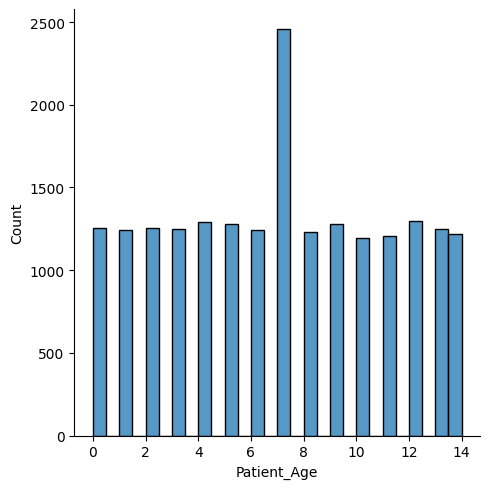

In [18]:
#plt.style.use('seaborn-dark')
sns.displot(x = 'Patient_Age', data = train_data);

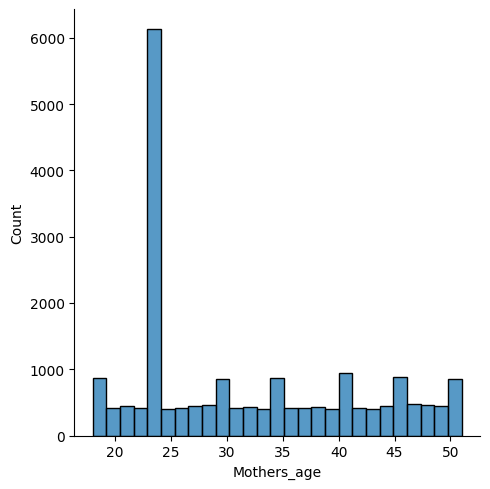

In [19]:
sns.displot(x = 'Mothers_age', data = train_data);

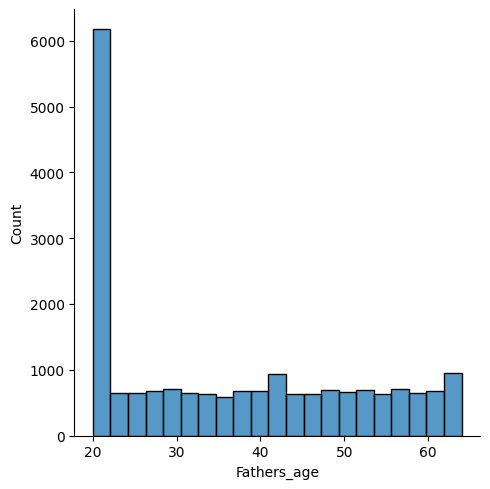

In [20]:
sns.displot(x = 'Fathers_age', data = train_data);

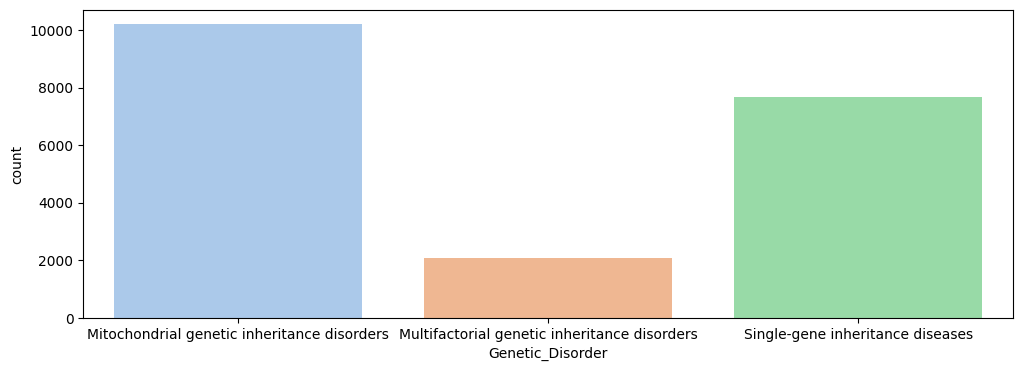

In [21]:

plt.figure(figsize=(12, 4))
sns.countplot(x = 'Genetic_Disorder', data = train_data,palette='pastel');

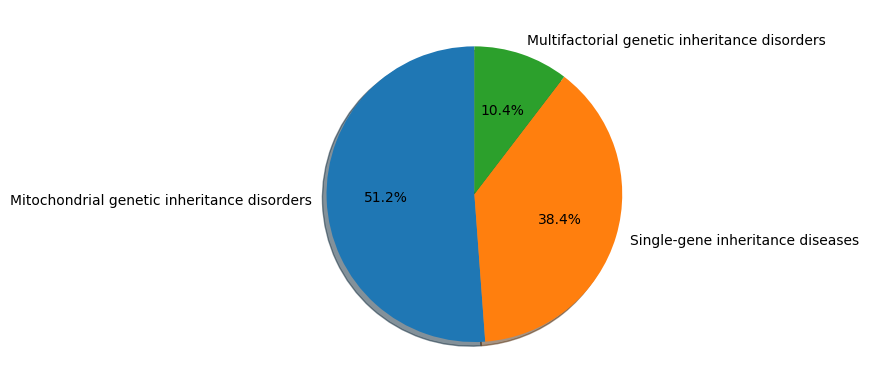

In [22]:
labels1 = 'Mitochondrial genetic inheritance disorders', 'Single-gene inheritance diseases', 'Multifactorial genetic inheritance disorders'
explode1 = (0, 0, 0)


plt.pie(train_data.Genetic_Disorder.value_counts(), explode=explode1, labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90);

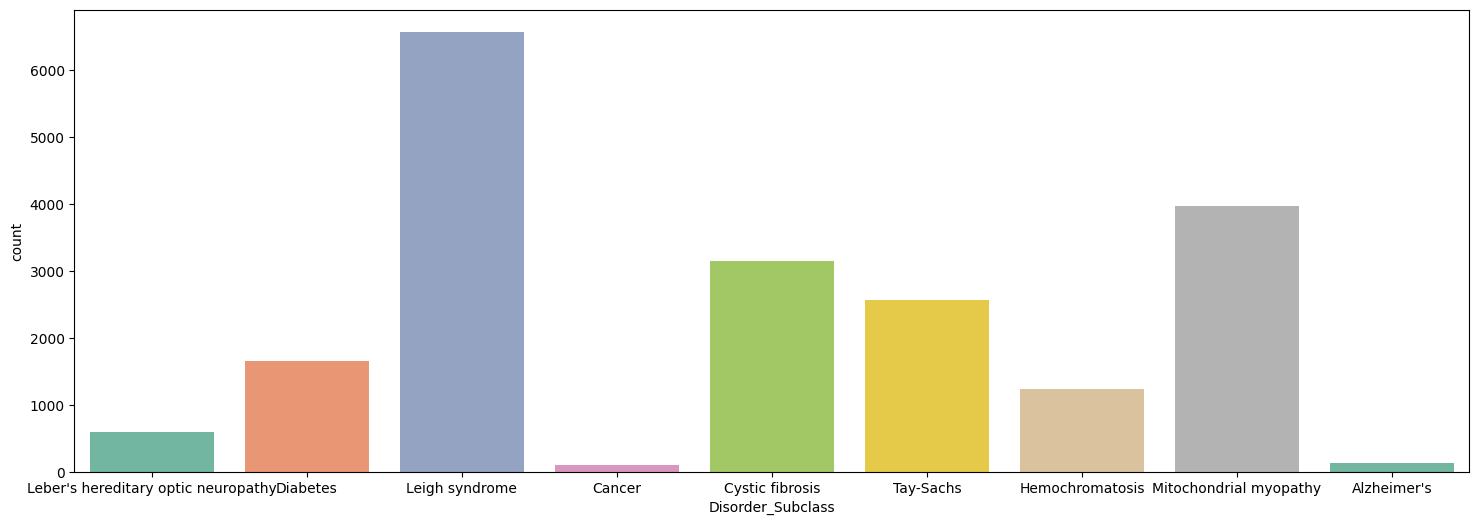

In [23]:
plt.figure(figsize=(18, 6))
sns.countplot(x = 'Disorder_Subclass', data = train_data, palette='Set2');

In [24]:
unique_subclasses = train_data.Disorder_Subclass.value_counts()
print(unique_subclasses)

Disorder_Subclass
Leigh syndrome                         6573
Mitochondrial myopathy                 3971
Cystic fibrosis                        3145
Tay-Sachs                              2556
Diabetes                               1653
Hemochromatosis                        1228
Leber's hereditary optic neuropathy     587
Alzheimer's                             133
Cancer                                   91
Name: count, dtype: int64


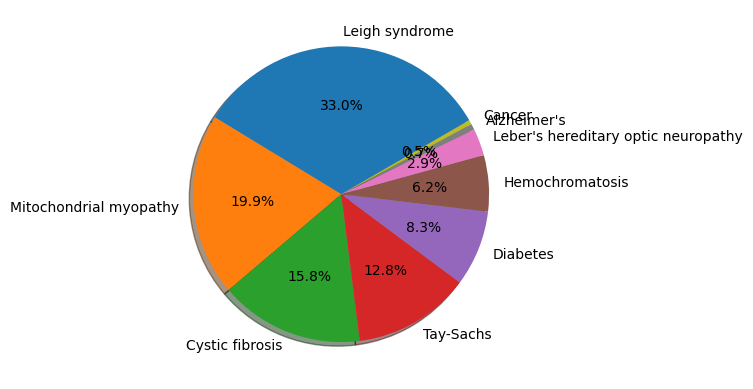

In [25]:

labels2 = ['Leigh syndrome', 'Mitochondrial myopathy', 'Cystic fibrosis', 'Tay-Sachs', 'Diabetes', 'Hemochromatosis',
"Leber's hereditary optic neuropathy", "Alzheimer's", 'Cancer']

explode2 = (0, 0, 0, 0, 0, 0, 0, 0,0)

plt.pie(train_data.Disorder_Subclass.value_counts(), explode=explode2, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=30);

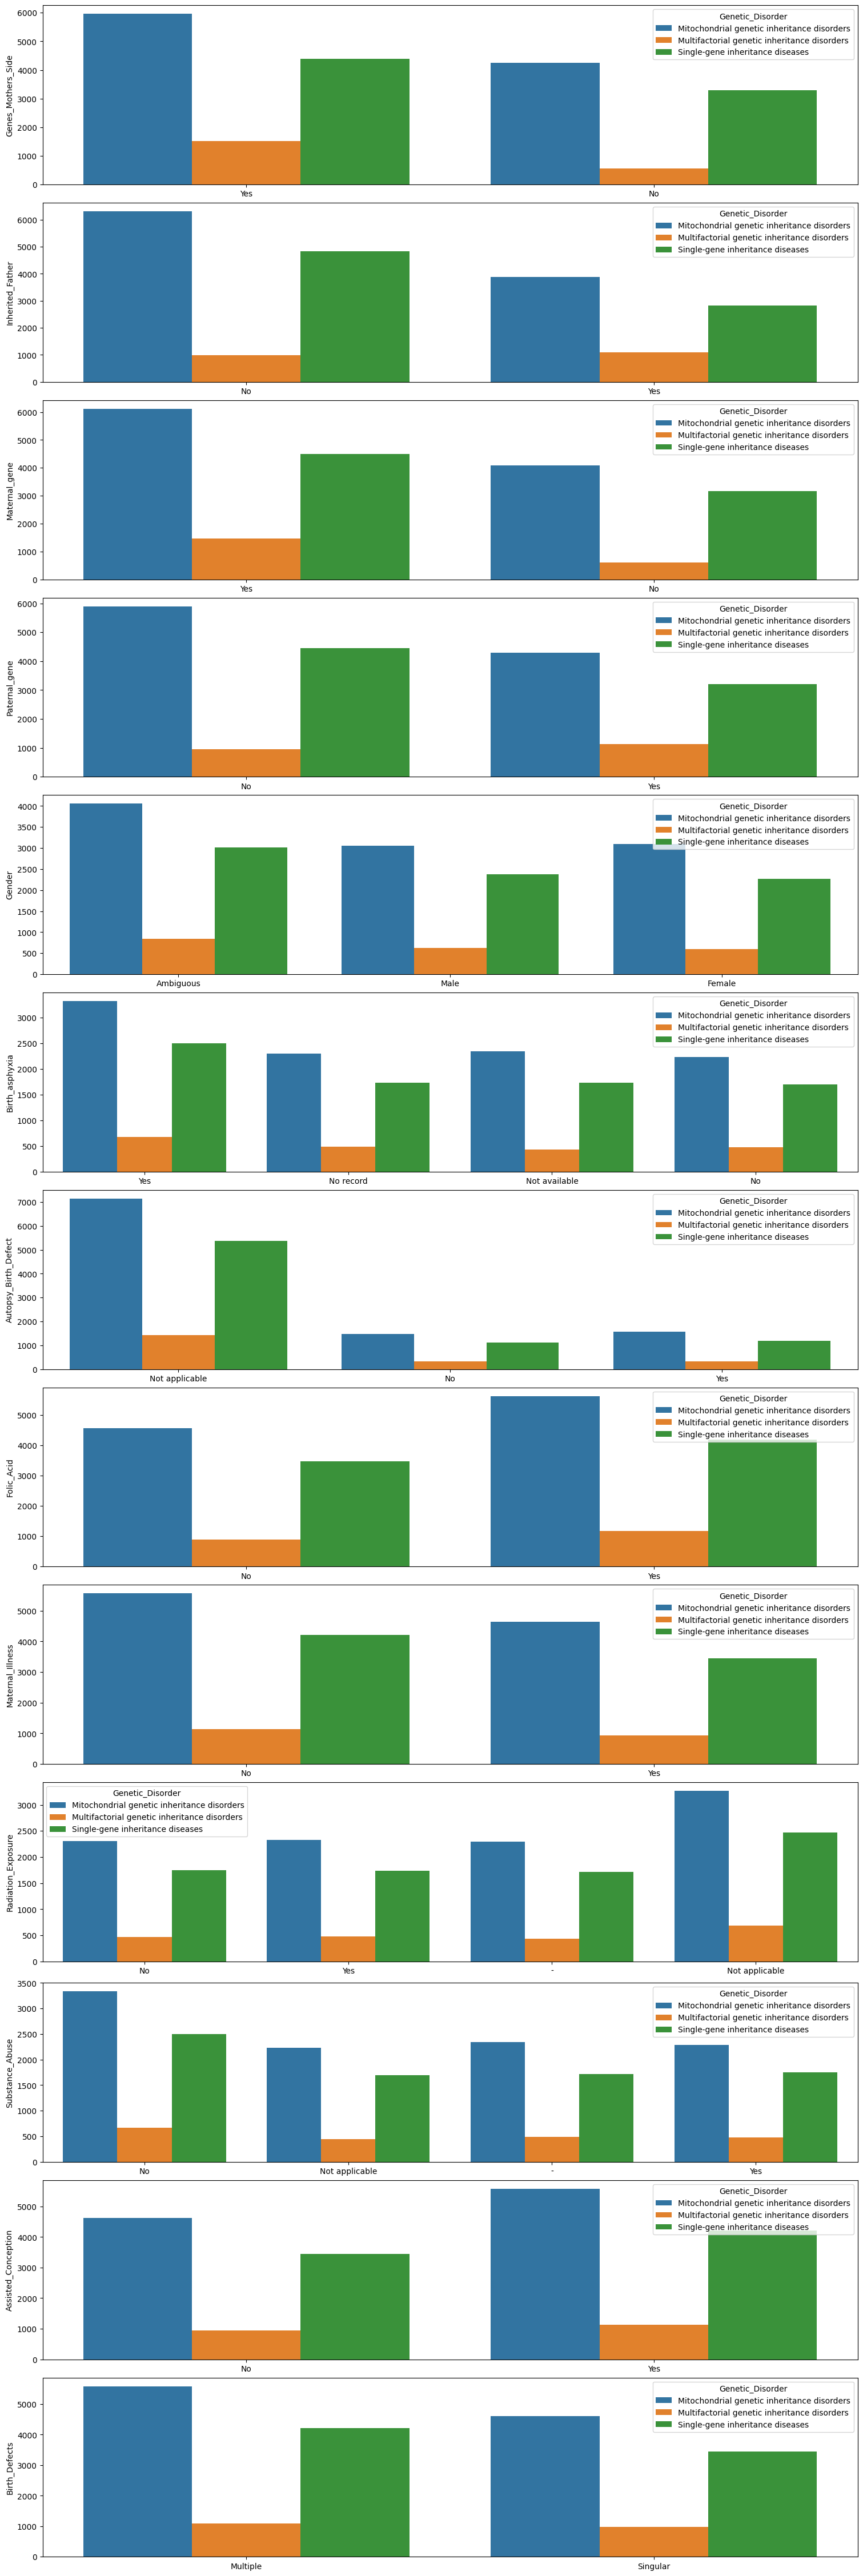

In [26]:
cols  = ['Genes_Mothers_Side', 'Inherited_Father', 'Maternal_gene', 'Paternal_gene', 
          'Gender', 'Birth_asphyxia', 'Autopsy_Birth_Defect', 
         'Folic_Acid',
        'Maternal_Illness',
         'Radiation_Exposure', 'Substance_Abuse', 'Assisted_Conception', 'Birth_Defects']


fig, ax = plt.subplots(len(cols),  figsize = (15, 45), constrained_layout = True)

for i, var in enumerate(cols): 
    sns.countplot(data = train_data, x = var, hue = 'Genetic_Disorder', ax = ax[i], linewidth = 1.5)
    ax[i].set_ylabel(var)
    ax[i].set_xlabel(None)

Encoding

In [27]:
encode_train_data = train_data.copy()

In [28]:
# Columns to encode
columns_to_encode = [
    "Genes_Mothers_Side", "Inherited_Father", "Maternal_gene", "Paternal_gene", "Status",
    "Respiratory_Rate_breaths_min", "Heart_Rates_Min", "Parental_consent", "Follow_up",
    "Gender", "Birth_asphyxia", "Autopsy_Birth_Defect", "Folic_Acid", "Maternal_Illness",
    "Radiation_Exposure", "Substance_Abuse", "Assisted_Conception", 
    "History_Previous_Pregnancies", "Birth_Defects", "Blood_test_result", 
    "Genetic_Disorder", "Disorder_Subclass"
]

# Dictionary to store mappings for each column
encoding_mappings = {}

# Loop through each column and encode using pd.factorize()
for col in columns_to_encode:
    # Encode the column and get the unique values
    encode_train_data[col], unique_values = pd.factorize(encode_train_data[col])
    
    # Store the mapping of encoded values to original values
    encoding_mappings[col] = {index: value for index, value in enumerate(unique_values)}

# Print each column's encoding mappings one below the other
for col, mapping in encoding_mappings.items():
    print(f"Encoding mapping for '{col}':")
    for encoded_value, original_value in mapping.items():
        print(f"  {encoded_value}: {original_value}")
    print("\n")  # Blank line between columns for readability


Encoding mapping for 'Genes_Mothers_Side':
  0: Yes
  1: No


Encoding mapping for 'Inherited_Father':
  0: No
  1: Yes


Encoding mapping for 'Maternal_gene':
  0: Yes
  1: No


Encoding mapping for 'Paternal_gene':
  0: No
  1: Yes


Encoding mapping for 'Status':
  0: Alive
  1: Deceased


Encoding mapping for 'Respiratory_Rate_breaths_min':
  0: Normal (30-60)
  1: Tachypnea


Encoding mapping for 'Heart_Rates_Min':
  0: Normal
  1: Tachycardia


Encoding mapping for 'Parental_consent':
  0: Yes


Encoding mapping for 'Follow_up':
  0: High
  1: Low


Encoding mapping for 'Gender':
  0: Ambiguous
  1: Male
  2: Female


Encoding mapping for 'Birth_asphyxia':
  0: Yes
  1: No record
  2: Not available
  3: No


Encoding mapping for 'Autopsy_Birth_Defect':
  0: Not applicable
  1: No
  2: Yes


Encoding mapping for 'Folic_Acid':
  0: No
  1: Yes


Encoding mapping for 'Maternal_Illness':
  0: No
  1: Yes


Encoding mapping for 'Radiation_Exposure':
  0: No
  1: Yes
  2: -
  3: Not ap

In [29]:
encode_train_data

,Patient_Age,Genes_Mothers_Side,Inherited_Father,Maternal_gene,Paternal_gene,Blood_Cell_mcL,Mothers_age,Fathers_age,Status,Respiratory_Rate_breaths_min,...,Radiation_Exposure,Substance_Abuse,Assisted_Conception,History_Previous_Pregnancies,Previous_Abortion,Birth_Defects,White_Blood_Cell,Blood_test_result,Genetic_Disorder,Disorder_Subclass
0,2.0,0,0,0,0,4.760603,23.0,20.0,0,0,...,0,0,0,0,2.0,0,9.857562,0,0,0
1,6.0,0,0,1,0,4.893297,41.0,22.0,0,0,...,1,0,1,0,4.0,1,7.472366,1,1,1
2,12.0,0,0,0,0,4.705280,21.0,20.0,1,1,...,2,1,1,0,1.0,1,7.919321,2,0,2
3,11.0,0,0,0,1,4.720703,32.0,20.0,0,1,...,2,1,1,1,4.0,0,4.098210,0,1,3
4,14.0,0,0,0,0,5.103188,23.0,20.0,1,0,...,0,0,1,1,0.0,0,10.272230,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,9.0,1,1,0,1,5.012599,47.0,20.0,1,0,...,0,1,1,0,2.0,0,12.000000,0,0,2
19933,4.0,0,1,0,0,5.258298,35.0,64.0,1,0,...,3,0,1,1,3.0,0,6.584811,2,0,2
19934,8.0,1,1,1,1,4.974220,23.0,56.0,0,0,...,0,2,1,1,2.0,0,7.041556,2,1,1
19935,8.0,0,0,0,0,5.186470,35.0,51.0,1,1,...,3,0,0,1,2.0,1,7.715464,1,0,7


Unique values in 'Genetic_Disorder': [0 1 2]


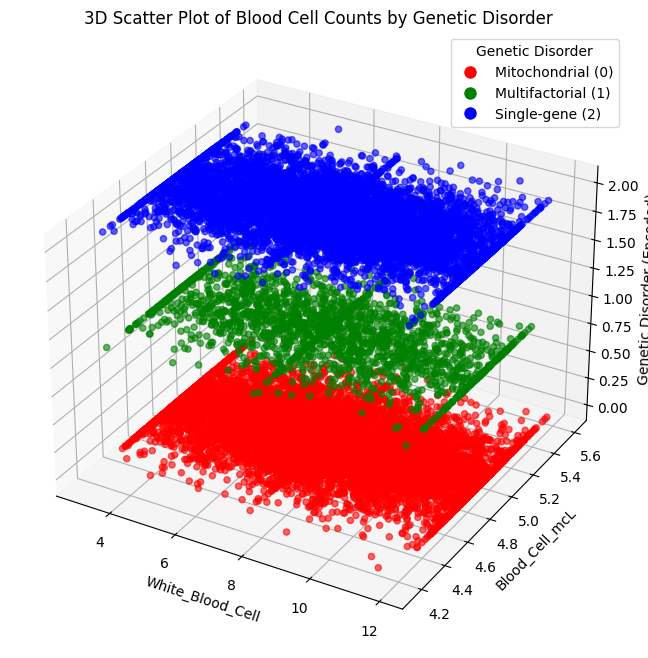

In [30]:
# Check unique values in the 'Genetic_Disorder' column
print("Unique values in 'Genetic_Disorder':", encode_train_data['Genetic_Disorder'].unique())


# Create a figure and a 3D subplot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for different Genetic_Disorder categories
colors = {0: 'r', 1: 'g', 2: 'b'}

# Create the 3D scatter plot
ax.scatter(
    encode_train_data['White_Blood_Cell'],
    encode_train_data['Blood_Cell_mcL'],
    encode_train_data['Genetic_Disorder'],
    c=encode_train_data['Genetic_Disorder'].map(colors),
    alpha=0.6
)

# Setting labels and title
ax.set_xlabel('White_Blood_Cell')
ax.set_ylabel('Blood_Cell_mcL')
ax.set_zlabel('Genetic Disorder (Encoded)')
ax.set_title('3D Scatter Plot of Blood Cell Counts by Genetic Disorder')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in colors.values()]
labels = ['Mitochondrial (0)', 'Multifactorial (1)', 'Single-gene (2)']
ax.legend(handles, labels, title='Genetic Disorder')

# Show the plot
plt.show()


In [31]:
#encode_train_data = encode_train_data.astype("float32")
encode_train_data

,Patient_Age,Genes_Mothers_Side,Inherited_Father,Maternal_gene,Paternal_gene,Blood_Cell_mcL,Mothers_age,Fathers_age,Status,Respiratory_Rate_breaths_min,...,Radiation_Exposure,Substance_Abuse,Assisted_Conception,History_Previous_Pregnancies,Previous_Abortion,Birth_Defects,White_Blood_Cell,Blood_test_result,Genetic_Disorder,Disorder_Subclass
0,2.0,0,0,0,0,4.760603,23.0,20.0,0,0,...,0,0,0,0,2.0,0,9.857562,0,0,0
1,6.0,0,0,1,0,4.893297,41.0,22.0,0,0,...,1,0,1,0,4.0,1,7.472366,1,1,1
2,12.0,0,0,0,0,4.705280,21.0,20.0,1,1,...,2,1,1,0,1.0,1,7.919321,2,0,2
3,11.0,0,0,0,1,4.720703,32.0,20.0,0,1,...,2,1,1,1,4.0,0,4.098210,0,1,3
4,14.0,0,0,0,0,5.103188,23.0,20.0,1,0,...,0,0,1,1,0.0,0,10.272230,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,9.0,1,1,0,1,5.012599,47.0,20.0,1,0,...,0,1,1,0,2.0,0,12.000000,0,0,2
19933,4.0,0,1,0,0,5.258298,35.0,64.0,1,0,...,3,0,1,1,3.0,0,6.584811,2,0,2
19934,8.0,1,1,1,1,4.974220,23.0,56.0,0,0,...,0,2,1,1,2.0,0,7.041556,2,1,1
19935,8.0,0,0,0,0,5.186470,35.0,51.0,1,1,...,3,0,0,1,2.0,1,7.715464,1,0,7


Model implementation before balancing

In [32]:
# Import necessary libraries
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
# Assuming 'Genetic Disorder' is the target column with the specified classes
X = encode_train_data.drop(['Genetic_Disorder'], axis=1)  # Drop the target column from features
y = encode_train_data['Genetic_Disorder']  # Set target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Define a mapping dictionary
disorder_mapping = {
    0: 'Mitochondrial genetic inheritance disorders',
    1: 'Multifactorial genetic inheritance disorders',
    2: 'Single-gene inheritance diseases'
}

# Map the numeric values to disorder names in y_train
y_train = y_train.map(disorder_mapping)


In [ ]:

# Define base classifiers
base_classifiers = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('svc', SVC(probability=True, random_state=42))
]

# Define the meta-classifier
meta_classifier = LogisticRegression()

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5
)

# Train the stacking classifier
stacking_classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = stacking_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=disorder_mapping.values()))

Accuracy: 0.0


ValueError: Mix of label input types (string and number)

Applying SMOTE for balancing

In [ ]:
# Assuming 'Genetic Disorder' is the target column with the specified classes
X = encode_train_data.drop(['Genetic_Disorder'], axis=1)  # Drop the target column from features
y = encode_train_data['Genetic_Disorder']  # Set target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for multiclass targets
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Display the class distribution after applying SMOTE
print("Class distribution before SMOTE:\n", y_train.value_counts())
print("Class distribution after SMOTE:\n", y_train_res.value_counts())


Class distribution before SMOTE:
 Genetic_Disorder
0    10202
2     7664
1     2071
Name: count, dtype: int64
Class distribution after SMOTE:
 Genetic_Disorder
0    10202
1    10202
2    10202
Name: count, dtype: int64


 0: Mitochondrial genetic inheritance disorders
  1: Multifactorial genetic inheritance disorders
  2: Single-gene inheritance diseases

In [ ]:

# Convert the SMOTE-resampled target data back into a DataFrame for plotting
y_train_res_df = pd.DataFrame(y_train_res, columns=['Genetic_Disorder'])

In [ ]:
# Define a mapping dictionary
disorder_mapping = {
    0: 'Mitochondrial genetic inheritance disorders',
    1: 'Multifactorial genetic inheritance disorders',
    2: 'Single-gene inheritance diseases'
}

# Map the numeric values to disorder names
y_train_res_df['Genetic_Disorder'] = y_train_res_df['Genetic_Disorder'].replace(disorder_mapping)


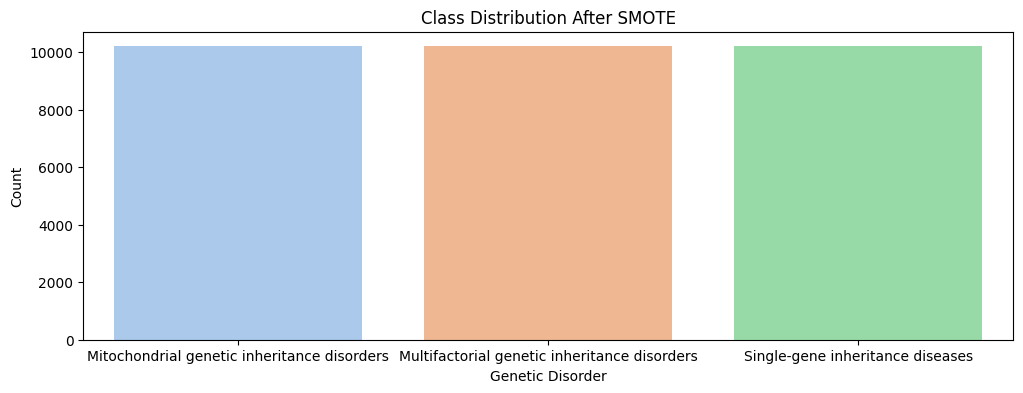

In [ ]:
# Plot the balanced class distribution
plt.figure(figsize=(12, 4))
sns.countplot(x='Genetic_Disorder', data=y_train_res_df, palette='pastel')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Genetic Disorder')
plt.ylabel('Count')
plt.show()


In [1]:
y_train_res_df

NameError: name 'y_train_res_df' is not defined

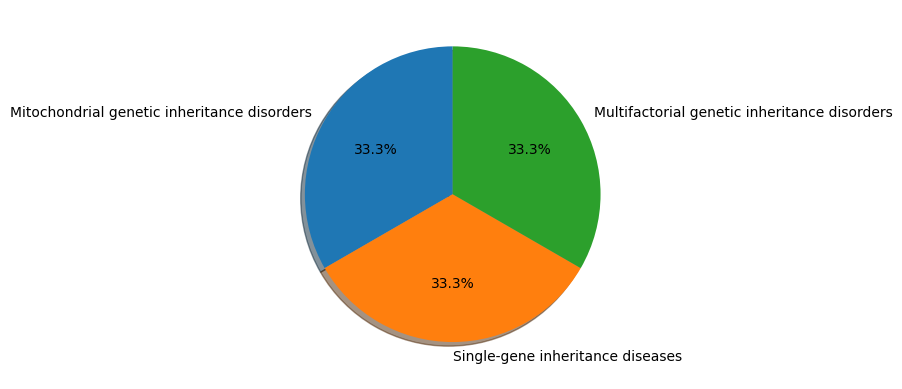

In [88]:
labels_disorder = 'Mitochondrial genetic inheritance disorders', 'Single-gene inheritance diseases', 'Multifactorial genetic inheritance disorders'
explode_disorder = (0, 0, 0)


plt.pie(y_train_res_df.Genetic_Disorder.value_counts(), explode=explode_disorder, labels=labels_disorder, autopct='%1.1f%%',
        shadow=True, startangle=90);

In [52]:
X_train_res.columns
#remove disorder subclass

Index(['Patient_Age', 'Genes_Mothers_Side', 'Inherited_Father',
       'Maternal_gene', 'Paternal_gene', 'Blood_Cell_mcL', 'Mothers_age',
       'Fathers_age', 'Status', 'Respiratory_Rate_breaths_min',
       'Heart_Rates_Min', 'Parental_consent', 'Follow_up', 'Gender',
       'Birth_asphyxia', 'Autopsy_Birth_Defect', 'Folic_Acid',
       'Maternal_Illness', 'Radiation_Exposure', 'Substance_Abuse',
       'Assisted_Conception', 'History_Previous_Pregnancies',
       'Previous_Abortion', 'Birth_Defects', 'White_Blood_Cell',
       'Blood_test_result', 'Disorder_Subclass'],
      dtype='object')

In [90]:
X_train_res_2 = X_train_res

In [92]:
# Assuming y_train_res is the resampled target variable from SMOTE
X_train_res_2['Genetic_Disorder'] = y_train_res.values

In [93]:
X_train_res_df = pd.DataFrame(X_train_res_2, columns=['Patient_Age', 'Genes_Mothers_Side', 'Inherited_Father',
       'Maternal_gene', 'Paternal_gene', 'Blood_Cell_mcL', 'Mothers_age',
       'Fathers_age', 'Status', 'Respiratory_Rate_breaths_min',
       'Heart_Rates_Min', 'Parental_consent', 'Follow_up', 'Gender',
       'Birth_asphyxia', 'Autopsy_Birth_Defect', 'Folic_Acid',
       'Maternal_Illness', 'Radiation_Exposure', 'Substance_Abuse',
       'Assisted_Conception', 'History_Previous_Pregnancies',
       'Previous_Abortion', 'Birth_Defects', 'White_Blood_Cell',
       'Blood_test_result', 'Disorder_Subclass', 'Genetic_Disorder'])

In [33]:
# Define a mapping dictionary
disorder_mapping = {
    0: 'Mitochondrial genetic inheritance disorders',
    1: 'Multifactorial genetic inheritance disorders',
    2: 'Single-gene inheritance diseases'
}

# Map the numeric values to disorder names
X_train_res_df['Genetic_Disorder'] = X_train_res_df['Genetic_Disorder'].replace(disorder_mapping)

NameError: name 'X_train_res_df' is not defined

Encoding mapping for 'Genes_Mothers_Side':
  0: Yes
  1: No


Encoding mapping for 'Inherited_Father':
  0: No
  1: Yes


Encoding mapping for 'Maternal_gene':
  0: Yes
  1: No


Encoding mapping for 'Paternal_gene':
  0: No
  1: Yes


Encoding mapping for 'Gender':
  0: Ambiguous
  1: Male
  2: Female


Encoding mapping for 'Birth_asphyxia':
  0: Yes
  1: No record
  2: Not available
  3: No


Encoding mapping for 'Autopsy_Birth_Defect':
  0: Not applicable
  1: No
  2: Yes


Encoding mapping for 'Folic_Acid':
  0: No
  1: Yes


Encoding mapping for 'Maternal_Illness':
  0: No
  1: Yes


Encoding mapping for 'Radiation_Exposure':
  0: No
  1: Yes
  2: -
  3: Not applicable


Encoding mapping for 'Substance_Abuse':
  0: No
  1: Not applicable
  2: -
  3: Yes


Encoding mapping for 'Assisted_Conception':
  0: No
  1: Yes


Encoding mapping for 'Birth_Defects':
  0: Multiple
  1: Singular


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns for plotting
cols = [
    'Genes_Mothers_Side', 'Inherited_Father', 'Maternal_gene', 'Paternal_gene', 
    'Gender', 'Birth_asphyxia', 'Autopsy_Birth_Defect', 
    'Folic_Acid', 'Maternal_Illness',
    'Radiation_Exposure', 'Substance_Abuse', 
    'Assisted_Conception', 'Birth_Defects'
]

# Create subplots
fig, ax = plt.subplots(len(cols), figsize=(15, 45), constrained_layout=True)

# Plot each categorical column with hue as 'Genetic_Disorder'
for i, var in enumerate(cols): 
    sns.countplot(data=X_train_res_df, x=var, hue='Genetic_Disorder', ax=ax[i], linewidth=1.5)
    ax[i].set_ylabel(var)
    ax[i].set_xlabel(None)

# Show the plots
plt.show()


# Implementing Models


In [59]:
# # Import necessary libraries
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, accuracy_score
# from xgboost import XGBClassifier

# # Define base classifiers
# base_classifiers = [
#     ('rf', RandomForestClassifier(random_state=42)),
#     ('gb', GradientBoostingClassifier(random_state=42)),
#     ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
#     ('svc', SVC(probability=True, random_state=42))
# ]

# # Define the meta-classifier
# meta_classifier = LogisticRegression()

# # Create the stacking classifier
# stacking_classifier = StackingClassifier(
#     estimators=base_classifiers,
#     final_estimator=meta_classifier,
#     cv=5
# )

# # Train the stacking classifier
# stacking_classifier.fit(X_train_res, y_train_res)

# # Make predictions on the test set
# y_pred = stacking_classifier.predict(X_test)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred, target_names=disorder_mapping.values()))

In [ ]:
# Import necessary libraries
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Define base classifiers
base_classifiers = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('svc', SVC(probability=True, random_state=42))
]

# Define the meta-classifier
meta_classifier = LogisticRegression()

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_classifier,
    cv=5
)

# Train the stacking classifier
stacking_classifier.fit(X_train_res, y_train_res)
X_test = encode_test_data
# Make predictions on the test set
y_pred = stacking_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=disorder_mapping.values()))

KeyboardInterrupt: 